## References:
1. https://www.analyticsvidhya.com/blog/2021/06/music-genres-classification-using-deep-learning-techniques/
2. https://data-flair.training/blogs/python-project-music-genre-classification/
3. https://blog.clairvoyantsoft.com/music-genre-classification-using-cnn-ef9461553726
4. https://github.com/AmbarZaidi/Audio-Genre-Classification
5. https://github.com/noahunallar/music-genre-recognition-using-neural-networks-and-k-means

### Papers

1)
Automatic Musical Genre Classification Of Audio Signals
http://ismir2001.ismir.net/pdf/tzanetakis.pdf 

2) Feature Extraction for Musical Genre Classification (2015 ) with reference to 1 
http://hpac.rwth-aachen.de/teaching/sem-mus-15/reports/Merkelbach.pdf

3) SONG-LEVEL FEATURES AND SUPPORT VECTOR MACHINES FOR MUSIC CLASSIFICATION
https://www.ee.columbia.edu/~dpwe/pubs/ismir05-svm.pdf

4) Music Genre Classification
http://cs229.stanford.edu/proj2011/HaggbladeHongKao-MusicGenreClassification.pdf

### Libraries

python_speech_features
http://python-speech-features.readthedocs.io/en/latest/
https://github.com/jameslyons/python_speech_features


MFCC tutorial
http://webcache.googleusercontent.com/search?q=cache:BlLUHkdAU_IJ:practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/+&cd=1&hl=en&ct=clnk&gl=in
http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/


Reading the signal 
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html

Hamming Window
https://docs.scipy.org/doc/numpy/reference/generated/numpy.hamming.html


## Some Findings 

- **Librosa** Library is to convert the music to the **spectograms**. Each music file will be one a spectogram
- The **Wavelet** Transform is a transformation that can be used to analyze the spectral and temporal properties of non-stationary signals like audio. **Librosa** library is to generate wavelets of each audio file.
- Also librosa.display will help to display 

### Comments by the already used methods 
- We train our CNN model for 500 epochs with Adam optimizer at a learning rate of 0.0001. We use categorical cross-entropy as the loss function [1]

### Small Discussion



## Libraries 

In [4]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from python_speech_features import mfcc
import pandas as pd
import numpy as np
from tempfile import TemporaryFile
import librosa, librosa.display
import json
import os
import math
import pickle
import random
import operator

In [5]:
wav_path = "./Data/genres_original/blues/blues.00000.wav"
signal, sr = librosa.load(wav_path, sr = 22050) #sr is sample rate, signal is 1D array, it is 20050 rates * 30 seconds
print(sr)

22050


In [6]:
print(signal)

[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]


### Time Domain

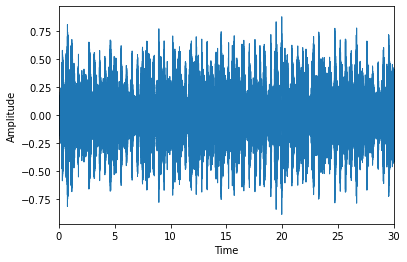

In [7]:
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Frequency Domain (Fast Fourier Transform)

In [8]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft) # indication of contribution of each frequency to the overall sound
frequency = np.linspace(0, sr, len(magnitude)) #gives a number of evenly spaced numbers in an interval. 
# Frequency interval is here 0 HZ and sample rate. Number of evenly paced values we want which is the length of magnitude


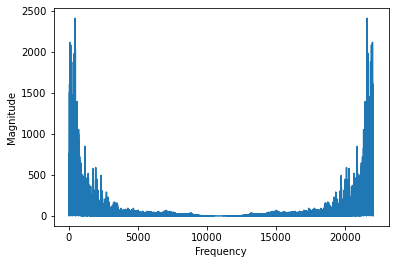

In [9]:
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### Interpretation
The first half of this is what brings us the novelty, the second half is the same information with the first half. Let's handle it by dividing it by two. 

In [10]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

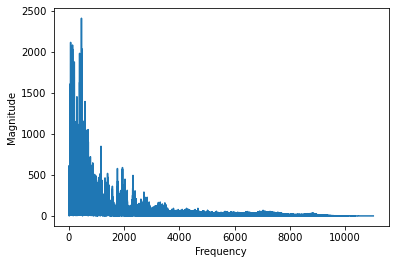

In [11]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [12]:
#number of samples per fft  (number of samples, window we're considering for performing a single fft)
n_fft = 2048
#amount we're shifting each fourier transform to the right. When we do STFT we slide an interval, 
#each interval we calculate a fft and hop_length will tell us how much we're shifting
hop_length = 512


In [13]:
stft = librosa.core.stft(signal, hop_length = hop_length, n_fft = n_fft)
spectogram = np.abs(stft)

In [14]:
log_spectogram = librosa.amplitude_to_db(spectogram)

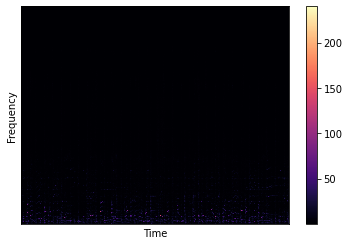

In [15]:
librosa.display.specshow(spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

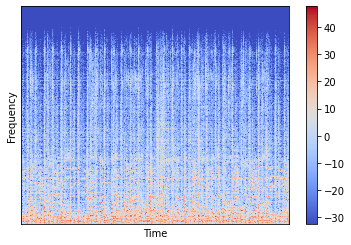

In [16]:
librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

### MFFCs (Mel Frequency Cepstral Coefficients)

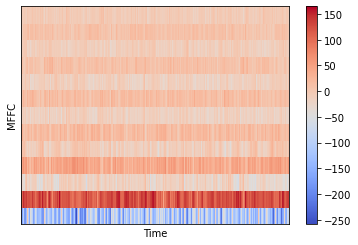

In [17]:
MFFCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFFCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFFC")
plt.colorbar()
plt.show()

### Preprocessing 
Extracting data from music dataset and writing to JSON 

In [21]:
DATASET_PATH = "./Data/genres_original"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION

In [22]:
#num_segments is needed for NN, which needs chunks of data, rather than one full segment. 

def save_mfcc(dataset_path, json_path, num_mfcc = 13, n_fft = 2048, hop_length = 512, num_segments = 5):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }
    #overall number of samples per track 
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/hop_length) #calculating mfcc by the hop_length (fourier shifting) and we need to ceil the value
    
    #looping through all the genres and 
    #dirpath - current, dirnames - subfolders, filenames - all file names 
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        #ensure that we're not att he root level
        if dirpath is not dataset_path:
            
            
            
            #save the semantic label, save the semantic (genre) levels
            dirpath_components = dirpath.split("/") #genre/blues will give us ["genre_original", "blues"]
            semantic_label = dirpath_components[-1] #consider the last, which is blues 
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))
            
            # process files for a specific genre
            for f in filenames: 
                
                #load audio file
                file_path = os.path.join(dirpath, f) #file path for the audio file 
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                
                # process segments extracting mfcc and storing data 
                for s in range(num_segments):
                    start_sample = num_samples_per_segment * s #s=0 -> 0
                    finish_sample = start_sample + num_samples_per_segment #s=0 -> num_samples_per_segment
                    
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

                    mfcc = mfcc.T
                    
                    # store mfcc for segment if it has the expected length 
                    if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, s+1))
                        
    with open(json_path, "w") as fp:
        json.dump(data,fp, indent=4)
                    


In [18]:
DATASET_PATH = "./Data/genres_original"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
      

In [23]:
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing pop
./Data/genres_original/pop/pop.00027.wav, segment:1
./Data/genres_original/pop/pop.00027.wav, segment:2
./Data/genres_original/pop/pop.00027.wav, segment:3
./Data/genres_original/pop/pop.00027.wav, segment:4
./Data/genres_original/pop/pop.00027.wav, segment:5
./Data/genres_original/pop/pop.00027.wav, segment:6
./Data/genres_original/pop/pop.00027.wav, segment:7
./Data/genres_original/pop/pop.00027.wav, segment:8
./Data/genres_original/pop/pop.00027.wav, segment:9
./Data/genres_original/pop/pop.00027.wav, segment:10
./Data/genres_original/pop/pop.00033.wav, segment:1
./Data/genres_original/pop/pop.00033.wav, segment:2
./Data/genres_original/pop/pop.00033.wav, segment:3
./Data/genres_original/pop/pop.00033.wav, segment:4
./Data/genres_original/pop/pop.00033.wav, segment:5
./Data/genres_original/pop/pop.00033.wav, segment:6
./Data/genres_original/pop/pop.00033.wav, segment:7
./Data/genres_original/pop/pop.00033.wav, segment:8
./Data/genres_original/pop/pop.00033.wav, segme

./Data/genres_original/pop/pop.00036.wav, segment:1
./Data/genres_original/pop/pop.00036.wav, segment:2
./Data/genres_original/pop/pop.00036.wav, segment:3
./Data/genres_original/pop/pop.00036.wav, segment:4
./Data/genres_original/pop/pop.00036.wav, segment:5
./Data/genres_original/pop/pop.00036.wav, segment:6
./Data/genres_original/pop/pop.00036.wav, segment:7
./Data/genres_original/pop/pop.00036.wav, segment:8
./Data/genres_original/pop/pop.00036.wav, segment:9
./Data/genres_original/pop/pop.00036.wav, segment:10
./Data/genres_original/pop/pop.00037.wav, segment:1
./Data/genres_original/pop/pop.00037.wav, segment:2
./Data/genres_original/pop/pop.00037.wav, segment:3
./Data/genres_original/pop/pop.00037.wav, segment:4
./Data/genres_original/pop/pop.00037.wav, segment:5
./Data/genres_original/pop/pop.00037.wav, segment:6
./Data/genres_original/pop/pop.00037.wav, segment:7
./Data/genres_original/pop/pop.00037.wav, segment:8
./Data/genres_original/pop/pop.00037.wav, segment:9
./Data/genr

./Data/genres_original/pop/pop.00085.wav, segment:3
./Data/genres_original/pop/pop.00085.wav, segment:4
./Data/genres_original/pop/pop.00085.wav, segment:5
./Data/genres_original/pop/pop.00085.wav, segment:6
./Data/genres_original/pop/pop.00085.wav, segment:7
./Data/genres_original/pop/pop.00085.wav, segment:8
./Data/genres_original/pop/pop.00085.wav, segment:9
./Data/genres_original/pop/pop.00085.wav, segment:10
./Data/genres_original/pop/pop.00091.wav, segment:1
./Data/genres_original/pop/pop.00091.wav, segment:2
./Data/genres_original/pop/pop.00091.wav, segment:3
./Data/genres_original/pop/pop.00091.wav, segment:4
./Data/genres_original/pop/pop.00091.wav, segment:5
./Data/genres_original/pop/pop.00091.wav, segment:6
./Data/genres_original/pop/pop.00091.wav, segment:7
./Data/genres_original/pop/pop.00091.wav, segment:8
./Data/genres_original/pop/pop.00091.wav, segment:9
./Data/genres_original/pop/pop.00091.wav, segment:10
./Data/genres_original/pop/pop.00046.wav, segment:1
./Data/gen

./Data/genres_original/pop/pop.00083.wav, segment:5
./Data/genres_original/pop/pop.00083.wav, segment:6
./Data/genres_original/pop/pop.00083.wav, segment:7
./Data/genres_original/pop/pop.00083.wav, segment:8
./Data/genres_original/pop/pop.00083.wav, segment:9
./Data/genres_original/pop/pop.00083.wav, segment:10
./Data/genres_original/pop/pop.00054.wav, segment:1
./Data/genres_original/pop/pop.00054.wav, segment:2
./Data/genres_original/pop/pop.00054.wav, segment:3
./Data/genres_original/pop/pop.00054.wav, segment:4
./Data/genres_original/pop/pop.00054.wav, segment:5
./Data/genres_original/pop/pop.00054.wav, segment:6
./Data/genres_original/pop/pop.00054.wav, segment:7
./Data/genres_original/pop/pop.00054.wav, segment:8
./Data/genres_original/pop/pop.00054.wav, segment:9
./Data/genres_original/pop/pop.00054.wav, segment:10
./Data/genres_original/pop/pop.00040.wav, segment:1
./Data/genres_original/pop/pop.00040.wav, segment:2
./Data/genres_original/pop/pop.00040.wav, segment:3
./Data/gen

./Data/genres_original/pop/pop.00089.wav, segment:2
./Data/genres_original/pop/pop.00089.wav, segment:3
./Data/genres_original/pop/pop.00089.wav, segment:4
./Data/genres_original/pop/pop.00089.wav, segment:5
./Data/genres_original/pop/pop.00089.wav, segment:6
./Data/genres_original/pop/pop.00089.wav, segment:7
./Data/genres_original/pop/pop.00089.wav, segment:8
./Data/genres_original/pop/pop.00089.wav, segment:9
./Data/genres_original/pop/pop.00089.wav, segment:10
./Data/genres_original/pop/pop.00062.wav, segment:1
./Data/genres_original/pop/pop.00062.wav, segment:2
./Data/genres_original/pop/pop.00062.wav, segment:3
./Data/genres_original/pop/pop.00062.wav, segment:4
./Data/genres_original/pop/pop.00062.wav, segment:5
./Data/genres_original/pop/pop.00062.wav, segment:6
./Data/genres_original/pop/pop.00062.wav, segment:7
./Data/genres_original/pop/pop.00062.wav, segment:8
./Data/genres_original/pop/pop.00062.wav, segment:9
./Data/genres_original/pop/pop.00062.wav, segment:10
./Data/gen

./Data/genres_original/pop/pop.00004.wav, segment:2
./Data/genres_original/pop/pop.00004.wav, segment:3
./Data/genres_original/pop/pop.00004.wav, segment:4
./Data/genres_original/pop/pop.00004.wav, segment:5
./Data/genres_original/pop/pop.00004.wav, segment:6
./Data/genres_original/pop/pop.00004.wav, segment:7
./Data/genres_original/pop/pop.00004.wav, segment:8
./Data/genres_original/pop/pop.00004.wav, segment:9
./Data/genres_original/pop/pop.00004.wav, segment:10
./Data/genres_original/pop/pop.00010.wav, segment:1
./Data/genres_original/pop/pop.00010.wav, segment:2
./Data/genres_original/pop/pop.00010.wav, segment:3
./Data/genres_original/pop/pop.00010.wav, segment:4
./Data/genres_original/pop/pop.00010.wav, segment:5
./Data/genres_original/pop/pop.00010.wav, segment:6
./Data/genres_original/pop/pop.00010.wav, segment:7
./Data/genres_original/pop/pop.00010.wav, segment:8
./Data/genres_original/pop/pop.00010.wav, segment:9
./Data/genres_original/pop/pop.00010.wav, segment:10
./Data/gen

./Data/genres_original/metal/metal.00021.wav, segment:3
./Data/genres_original/metal/metal.00021.wav, segment:4
./Data/genres_original/metal/metal.00021.wav, segment:5
./Data/genres_original/metal/metal.00021.wav, segment:6
./Data/genres_original/metal/metal.00021.wav, segment:7
./Data/genres_original/metal/metal.00021.wav, segment:8
./Data/genres_original/metal/metal.00021.wav, segment:9
./Data/genres_original/metal/metal.00021.wav, segment:10
./Data/genres_original/metal/metal.00020.wav, segment:1
./Data/genres_original/metal/metal.00020.wav, segment:2
./Data/genres_original/metal/metal.00020.wav, segment:3
./Data/genres_original/metal/metal.00020.wav, segment:4
./Data/genres_original/metal/metal.00020.wav, segment:5
./Data/genres_original/metal/metal.00020.wav, segment:6
./Data/genres_original/metal/metal.00020.wav, segment:7
./Data/genres_original/metal/metal.00020.wav, segment:8
./Data/genres_original/metal/metal.00020.wav, segment:9
./Data/genres_original/metal/metal.00020.wav, s

./Data/genres_original/metal/metal.00096.wav, segment:1
./Data/genres_original/metal/metal.00096.wav, segment:2
./Data/genres_original/metal/metal.00096.wav, segment:3
./Data/genres_original/metal/metal.00096.wav, segment:4
./Data/genres_original/metal/metal.00096.wav, segment:5
./Data/genres_original/metal/metal.00096.wav, segment:6
./Data/genres_original/metal/metal.00096.wav, segment:7
./Data/genres_original/metal/metal.00096.wav, segment:8
./Data/genres_original/metal/metal.00096.wav, segment:9
./Data/genres_original/metal/metal.00096.wav, segment:10
./Data/genres_original/metal/metal.00069.wav, segment:1
./Data/genres_original/metal/metal.00069.wav, segment:2
./Data/genres_original/metal/metal.00069.wav, segment:3
./Data/genres_original/metal/metal.00069.wav, segment:4
./Data/genres_original/metal/metal.00069.wav, segment:5
./Data/genres_original/metal/metal.00069.wav, segment:6
./Data/genres_original/metal/metal.00069.wav, segment:7
./Data/genres_original/metal/metal.00069.wav, s

./Data/genres_original/metal/metal.00080.wav, segment:1
./Data/genres_original/metal/metal.00080.wav, segment:2
./Data/genres_original/metal/metal.00080.wav, segment:3
./Data/genres_original/metal/metal.00080.wav, segment:4
./Data/genres_original/metal/metal.00080.wav, segment:5
./Data/genres_original/metal/metal.00080.wav, segment:6
./Data/genres_original/metal/metal.00080.wav, segment:7
./Data/genres_original/metal/metal.00080.wav, segment:8
./Data/genres_original/metal/metal.00080.wav, segment:9
./Data/genres_original/metal/metal.00080.wav, segment:10
./Data/genres_original/metal/metal.00094.wav, segment:1
./Data/genres_original/metal/metal.00094.wav, segment:2
./Data/genres_original/metal/metal.00094.wav, segment:3
./Data/genres_original/metal/metal.00094.wav, segment:4
./Data/genres_original/metal/metal.00094.wav, segment:5
./Data/genres_original/metal/metal.00094.wav, segment:6
./Data/genres_original/metal/metal.00094.wav, segment:7
./Data/genres_original/metal/metal.00094.wav, s

./Data/genres_original/metal/metal.00078.wav, segment:9
./Data/genres_original/metal/metal.00078.wav, segment:10
./Data/genres_original/metal/metal.00079.wav, segment:1
./Data/genres_original/metal/metal.00079.wav, segment:2
./Data/genres_original/metal/metal.00079.wav, segment:3
./Data/genres_original/metal/metal.00079.wav, segment:4
./Data/genres_original/metal/metal.00079.wav, segment:5
./Data/genres_original/metal/metal.00079.wav, segment:6
./Data/genres_original/metal/metal.00079.wav, segment:7
./Data/genres_original/metal/metal.00079.wav, segment:8
./Data/genres_original/metal/metal.00079.wav, segment:9
./Data/genres_original/metal/metal.00079.wav, segment:10
./Data/genres_original/metal/metal.00051.wav, segment:1
./Data/genres_original/metal/metal.00051.wav, segment:2
./Data/genres_original/metal/metal.00051.wav, segment:3
./Data/genres_original/metal/metal.00051.wav, segment:4
./Data/genres_original/metal/metal.00051.wav, segment:5
./Data/genres_original/metal/metal.00051.wav, 

./Data/genres_original/metal/metal.00099.wav, segment:10
./Data/genres_original/metal/metal.00072.wav, segment:1
./Data/genres_original/metal/metal.00072.wav, segment:2
./Data/genres_original/metal/metal.00072.wav, segment:3
./Data/genres_original/metal/metal.00072.wav, segment:4
./Data/genres_original/metal/metal.00072.wav, segment:5
./Data/genres_original/metal/metal.00072.wav, segment:6
./Data/genres_original/metal/metal.00072.wav, segment:7
./Data/genres_original/metal/metal.00072.wav, segment:8
./Data/genres_original/metal/metal.00072.wav, segment:9
./Data/genres_original/metal/metal.00072.wav, segment:10
./Data/genres_original/metal/metal.00066.wav, segment:1
./Data/genres_original/metal/metal.00066.wav, segment:2
./Data/genres_original/metal/metal.00066.wav, segment:3
./Data/genres_original/metal/metal.00066.wav, segment:4
./Data/genres_original/metal/metal.00066.wav, segment:5
./Data/genres_original/metal/metal.00066.wav, segment:6
./Data/genres_original/metal/metal.00066.wav, 

./Data/genres_original/metal/metal.00014.wav, segment:8
./Data/genres_original/metal/metal.00014.wav, segment:9
./Data/genres_original/metal/metal.00014.wav, segment:10
./Data/genres_original/metal/metal.00000.wav, segment:1
./Data/genres_original/metal/metal.00000.wav, segment:2
./Data/genres_original/metal/metal.00000.wav, segment:3
./Data/genres_original/metal/metal.00000.wav, segment:4
./Data/genres_original/metal/metal.00000.wav, segment:5
./Data/genres_original/metal/metal.00000.wav, segment:6
./Data/genres_original/metal/metal.00000.wav, segment:7
./Data/genres_original/metal/metal.00000.wav, segment:8
./Data/genres_original/metal/metal.00000.wav, segment:9
./Data/genres_original/metal/metal.00000.wav, segment:10
./Data/genres_original/metal/metal.00001.wav, segment:1
./Data/genres_original/metal/metal.00001.wav, segment:2
./Data/genres_original/metal/metal.00001.wav, segment:3
./Data/genres_original/metal/metal.00001.wav, segment:4
./Data/genres_original/metal/metal.00001.wav, 

./Data/genres_original/disco/disco.00046.wav, segment:2
./Data/genres_original/disco/disco.00046.wav, segment:3
./Data/genres_original/disco/disco.00046.wav, segment:4
./Data/genres_original/disco/disco.00046.wav, segment:5
./Data/genres_original/disco/disco.00046.wav, segment:6
./Data/genres_original/disco/disco.00046.wav, segment:7
./Data/genres_original/disco/disco.00046.wav, segment:8
./Data/genres_original/disco/disco.00046.wav, segment:9
./Data/genres_original/disco/disco.00046.wav, segment:10
./Data/genres_original/disco/disco.00091.wav, segment:1
./Data/genres_original/disco/disco.00091.wav, segment:2
./Data/genres_original/disco/disco.00091.wav, segment:3
./Data/genres_original/disco/disco.00091.wav, segment:4
./Data/genres_original/disco/disco.00091.wav, segment:5
./Data/genres_original/disco/disco.00091.wav, segment:6
./Data/genres_original/disco/disco.00091.wav, segment:7
./Data/genres_original/disco/disco.00091.wav, segment:8
./Data/genres_original/disco/disco.00091.wav, s

./Data/genres_original/disco/disco.00050.wav, segment:8
./Data/genres_original/disco/disco.00050.wav, segment:9
./Data/genres_original/disco/disco.00050.wav, segment:10
./Data/genres_original/disco/disco.00044.wav, segment:1
./Data/genres_original/disco/disco.00044.wav, segment:2
./Data/genres_original/disco/disco.00044.wav, segment:3
./Data/genres_original/disco/disco.00044.wav, segment:4
./Data/genres_original/disco/disco.00044.wav, segment:5
./Data/genres_original/disco/disco.00044.wav, segment:6
./Data/genres_original/disco/disco.00044.wav, segment:7
./Data/genres_original/disco/disco.00044.wav, segment:8
./Data/genres_original/disco/disco.00044.wav, segment:9
./Data/genres_original/disco/disco.00044.wav, segment:10
./Data/genres_original/disco/disco.00068.wav, segment:1
./Data/genres_original/disco/disco.00068.wav, segment:2
./Data/genres_original/disco/disco.00068.wav, segment:3
./Data/genres_original/disco/disco.00068.wav, segment:4
./Data/genres_original/disco/disco.00068.wav, 

./Data/genres_original/disco/disco.00081.wav, segment:2
./Data/genres_original/disco/disco.00081.wav, segment:3
./Data/genres_original/disco/disco.00081.wav, segment:4
./Data/genres_original/disco/disco.00081.wav, segment:5
./Data/genres_original/disco/disco.00081.wav, segment:6
./Data/genres_original/disco/disco.00081.wav, segment:7
./Data/genres_original/disco/disco.00081.wav, segment:8
./Data/genres_original/disco/disco.00081.wav, segment:9
./Data/genres_original/disco/disco.00081.wav, segment:10
./Data/genres_original/disco/disco.00095.wav, segment:1
./Data/genres_original/disco/disco.00095.wav, segment:2
./Data/genres_original/disco/disco.00095.wav, segment:3
./Data/genres_original/disco/disco.00095.wav, segment:4
./Data/genres_original/disco/disco.00095.wav, segment:5
./Data/genres_original/disco/disco.00095.wav, segment:6
./Data/genres_original/disco/disco.00095.wav, segment:7
./Data/genres_original/disco/disco.00095.wav, segment:8
./Data/genres_original/disco/disco.00095.wav, s

./Data/genres_original/disco/disco.00036.wav, segment:1
./Data/genres_original/disco/disco.00036.wav, segment:2
./Data/genres_original/disco/disco.00036.wav, segment:3
./Data/genres_original/disco/disco.00036.wav, segment:4
./Data/genres_original/disco/disco.00036.wav, segment:5
./Data/genres_original/disco/disco.00036.wav, segment:6
./Data/genres_original/disco/disco.00036.wav, segment:7
./Data/genres_original/disco/disco.00036.wav, segment:8
./Data/genres_original/disco/disco.00036.wav, segment:9
./Data/genres_original/disco/disco.00036.wav, segment:10
./Data/genres_original/disco/disco.00022.wav, segment:1
./Data/genres_original/disco/disco.00022.wav, segment:2
./Data/genres_original/disco/disco.00022.wav, segment:3
./Data/genres_original/disco/disco.00022.wav, segment:4
./Data/genres_original/disco/disco.00022.wav, segment:5
./Data/genres_original/disco/disco.00022.wav, segment:6
./Data/genres_original/disco/disco.00022.wav, segment:7
./Data/genres_original/disco/disco.00022.wav, s

./Data/genres_original/disco/disco.00006.wav, segment:10
./Data/genres_original/disco/disco.00002.wav, segment:1
./Data/genres_original/disco/disco.00002.wav, segment:2
./Data/genres_original/disco/disco.00002.wav, segment:3
./Data/genres_original/disco/disco.00002.wav, segment:4
./Data/genres_original/disco/disco.00002.wav, segment:5
./Data/genres_original/disco/disco.00002.wav, segment:6
./Data/genres_original/disco/disco.00002.wav, segment:7
./Data/genres_original/disco/disco.00002.wav, segment:8
./Data/genres_original/disco/disco.00002.wav, segment:9
./Data/genres_original/disco/disco.00002.wav, segment:10
./Data/genres_original/disco/disco.00016.wav, segment:1
./Data/genres_original/disco/disco.00016.wav, segment:2
./Data/genres_original/disco/disco.00016.wav, segment:3
./Data/genres_original/disco/disco.00016.wav, segment:4
./Data/genres_original/disco/disco.00016.wav, segment:5
./Data/genres_original/disco/disco.00016.wav, segment:6
./Data/genres_original/disco/disco.00016.wav, 

./Data/genres_original/disco/disco.00058.wav, segment:2
./Data/genres_original/disco/disco.00058.wav, segment:3
./Data/genres_original/disco/disco.00058.wav, segment:4
./Data/genres_original/disco/disco.00058.wav, segment:5
./Data/genres_original/disco/disco.00058.wav, segment:6
./Data/genres_original/disco/disco.00058.wav, segment:7
./Data/genres_original/disco/disco.00058.wav, segment:8
./Data/genres_original/disco/disco.00058.wav, segment:9
./Data/genres_original/disco/disco.00058.wav, segment:10
./Data/genres_original/disco/disco.00059.wav, segment:1
./Data/genres_original/disco/disco.00059.wav, segment:2
./Data/genres_original/disco/disco.00059.wav, segment:3
./Data/genres_original/disco/disco.00059.wav, segment:4
./Data/genres_original/disco/disco.00059.wav, segment:5
./Data/genres_original/disco/disco.00059.wav, segment:6
./Data/genres_original/disco/disco.00059.wav, segment:7
./Data/genres_original/disco/disco.00059.wav, segment:8
./Data/genres_original/disco/disco.00059.wav, s

./Data/genres_original/blues/blues.00050.wav, segment:3
./Data/genres_original/blues/blues.00050.wav, segment:4
./Data/genres_original/blues/blues.00050.wav, segment:5
./Data/genres_original/blues/blues.00050.wav, segment:6
./Data/genres_original/blues/blues.00050.wav, segment:7
./Data/genres_original/blues/blues.00050.wav, segment:8
./Data/genres_original/blues/blues.00050.wav, segment:9
./Data/genres_original/blues/blues.00050.wav, segment:10
./Data/genres_original/blues/blues.00044.wav, segment:1
./Data/genres_original/blues/blues.00044.wav, segment:2
./Data/genres_original/blues/blues.00044.wav, segment:3
./Data/genres_original/blues/blues.00044.wav, segment:4
./Data/genres_original/blues/blues.00044.wav, segment:5
./Data/genres_original/blues/blues.00044.wav, segment:6
./Data/genres_original/blues/blues.00044.wav, segment:7
./Data/genres_original/blues/blues.00044.wav, segment:8
./Data/genres_original/blues/blues.00044.wav, segment:9
./Data/genres_original/blues/blues.00044.wav, s

./Data/genres_original/blues/blues.00095.wav, segment:9
./Data/genres_original/blues/blues.00095.wav, segment:10
./Data/genres_original/blues/blues.00042.wav, segment:1
./Data/genres_original/blues/blues.00042.wav, segment:2
./Data/genres_original/blues/blues.00042.wav, segment:3
./Data/genres_original/blues/blues.00042.wav, segment:4
./Data/genres_original/blues/blues.00042.wav, segment:5
./Data/genres_original/blues/blues.00042.wav, segment:6
./Data/genres_original/blues/blues.00042.wav, segment:7
./Data/genres_original/blues/blues.00042.wav, segment:8
./Data/genres_original/blues/blues.00042.wav, segment:9
./Data/genres_original/blues/blues.00042.wav, segment:10
./Data/genres_original/blues/blues.00056.wav, segment:1
./Data/genres_original/blues/blues.00056.wav, segment:2
./Data/genres_original/blues/blues.00056.wav, segment:3
./Data/genres_original/blues/blues.00056.wav, segment:4
./Data/genres_original/blues/blues.00056.wav, segment:5
./Data/genres_original/blues/blues.00056.wav, 

./Data/genres_original/blues/blues.00027.wav, segment:2
./Data/genres_original/blues/blues.00027.wav, segment:3
./Data/genres_original/blues/blues.00027.wav, segment:4
./Data/genres_original/blues/blues.00027.wav, segment:5
./Data/genres_original/blues/blues.00027.wav, segment:6
./Data/genres_original/blues/blues.00027.wav, segment:7
./Data/genres_original/blues/blues.00027.wav, segment:8
./Data/genres_original/blues/blues.00027.wav, segment:9
./Data/genres_original/blues/blues.00027.wav, segment:10
./Data/genres_original/blues/blues.00026.wav, segment:1
./Data/genres_original/blues/blues.00026.wav, segment:2
./Data/genres_original/blues/blues.00026.wav, segment:3
./Data/genres_original/blues/blues.00026.wav, segment:4
./Data/genres_original/blues/blues.00026.wav, segment:5
./Data/genres_original/blues/blues.00026.wav, segment:6
./Data/genres_original/blues/blues.00026.wav, segment:7
./Data/genres_original/blues/blues.00026.wav, segment:8
./Data/genres_original/blues/blues.00026.wav, s

./Data/genres_original/blues/blues.00037.wav, segment:2
./Data/genres_original/blues/blues.00037.wav, segment:3
./Data/genres_original/blues/blues.00037.wav, segment:4
./Data/genres_original/blues/blues.00037.wav, segment:5
./Data/genres_original/blues/blues.00037.wav, segment:6
./Data/genres_original/blues/blues.00037.wav, segment:7
./Data/genres_original/blues/blues.00037.wav, segment:8
./Data/genres_original/blues/blues.00037.wav, segment:9
./Data/genres_original/blues/blues.00037.wav, segment:10
./Data/genres_original/blues/blues.00012.wav, segment:1
./Data/genres_original/blues/blues.00012.wav, segment:2
./Data/genres_original/blues/blues.00012.wav, segment:3
./Data/genres_original/blues/blues.00012.wav, segment:4
./Data/genres_original/blues/blues.00012.wav, segment:5
./Data/genres_original/blues/blues.00012.wav, segment:6
./Data/genres_original/blues/blues.00012.wav, segment:7
./Data/genres_original/blues/blues.00012.wav, segment:8
./Data/genres_original/blues/blues.00012.wav, s

./Data/genres_original/blues/blues.00017.wav, segment:10
./Data/genres_original/blues/blues.00003.wav, segment:1
./Data/genres_original/blues/blues.00003.wav, segment:2
./Data/genres_original/blues/blues.00003.wav, segment:3
./Data/genres_original/blues/blues.00003.wav, segment:4
./Data/genres_original/blues/blues.00003.wav, segment:5
./Data/genres_original/blues/blues.00003.wav, segment:6
./Data/genres_original/blues/blues.00003.wav, segment:7
./Data/genres_original/blues/blues.00003.wav, segment:8
./Data/genres_original/blues/blues.00003.wav, segment:9
./Data/genres_original/blues/blues.00003.wav, segment:10
./Data/genres_original/blues/blues.00002.wav, segment:1
./Data/genres_original/blues/blues.00002.wav, segment:2
./Data/genres_original/blues/blues.00002.wav, segment:3
./Data/genres_original/blues/blues.00002.wav, segment:4
./Data/genres_original/blues/blues.00002.wav, segment:5
./Data/genres_original/blues/blues.00002.wav, segment:6
./Data/genres_original/blues/blues.00002.wav, 

./Data/genres_original/blues/blues.00077.wav, segment:10
./Data/genres_original/blues/blues.00076.wav, segment:1
./Data/genres_original/blues/blues.00076.wav, segment:2
./Data/genres_original/blues/blues.00076.wav, segment:3
./Data/genres_original/blues/blues.00076.wav, segment:4
./Data/genres_original/blues/blues.00076.wav, segment:5
./Data/genres_original/blues/blues.00076.wav, segment:6
./Data/genres_original/blues/blues.00076.wav, segment:7
./Data/genres_original/blues/blues.00076.wav, segment:8
./Data/genres_original/blues/blues.00076.wav, segment:9
./Data/genres_original/blues/blues.00076.wav, segment:10
./Data/genres_original/blues/blues.00062.wav, segment:1
./Data/genres_original/blues/blues.00062.wav, segment:2
./Data/genres_original/blues/blues.00062.wav, segment:3
./Data/genres_original/blues/blues.00062.wav, segment:4
./Data/genres_original/blues/blues.00062.wav, segment:5
./Data/genres_original/blues/blues.00062.wav, segment:6
./Data/genres_original/blues/blues.00062.wav, 

./Data/genres_original/reggae/reggae.00097.wav, segment:5
./Data/genres_original/reggae/reggae.00097.wav, segment:6
./Data/genres_original/reggae/reggae.00097.wav, segment:7
./Data/genres_original/reggae/reggae.00097.wav, segment:8
./Data/genres_original/reggae/reggae.00097.wav, segment:9
./Data/genres_original/reggae/reggae.00097.wav, segment:10
./Data/genres_original/reggae/reggae.00083.wav, segment:1
./Data/genres_original/reggae/reggae.00083.wav, segment:2
./Data/genres_original/reggae/reggae.00083.wav, segment:3
./Data/genres_original/reggae/reggae.00083.wav, segment:4
./Data/genres_original/reggae/reggae.00083.wav, segment:5
./Data/genres_original/reggae/reggae.00083.wav, segment:6
./Data/genres_original/reggae/reggae.00083.wav, segment:7
./Data/genres_original/reggae/reggae.00083.wav, segment:8
./Data/genres_original/reggae/reggae.00083.wav, segment:9
./Data/genres_original/reggae/reggae.00083.wav, segment:10
./Data/genres_original/reggae/reggae.00054.wav, segment:1
./Data/genre

./Data/genres_original/reggae/reggae.00078.wav, segment:1
./Data/genres_original/reggae/reggae.00078.wav, segment:2
./Data/genres_original/reggae/reggae.00078.wav, segment:3
./Data/genres_original/reggae/reggae.00078.wav, segment:4
./Data/genres_original/reggae/reggae.00078.wav, segment:5
./Data/genres_original/reggae/reggae.00078.wav, segment:6
./Data/genres_original/reggae/reggae.00078.wav, segment:7
./Data/genres_original/reggae/reggae.00078.wav, segment:8
./Data/genres_original/reggae/reggae.00078.wav, segment:9
./Data/genres_original/reggae/reggae.00078.wav, segment:10
./Data/genres_original/reggae/reggae.00087.wav, segment:1
./Data/genres_original/reggae/reggae.00087.wav, segment:2
./Data/genres_original/reggae/reggae.00087.wav, segment:3
./Data/genres_original/reggae/reggae.00087.wav, segment:4
./Data/genres_original/reggae/reggae.00087.wav, segment:5
./Data/genres_original/reggae/reggae.00087.wav, segment:6
./Data/genres_original/reggae/reggae.00087.wav, segment:7
./Data/genres

./Data/genres_original/reggae/reggae.00037.wav, segment:7
./Data/genres_original/reggae/reggae.00037.wav, segment:8
./Data/genres_original/reggae/reggae.00037.wav, segment:9
./Data/genres_original/reggae/reggae.00037.wav, segment:10
./Data/genres_original/reggae/reggae.00023.wav, segment:1
./Data/genres_original/reggae/reggae.00023.wav, segment:2
./Data/genres_original/reggae/reggae.00023.wav, segment:3
./Data/genres_original/reggae/reggae.00023.wav, segment:4
./Data/genres_original/reggae/reggae.00023.wav, segment:5
./Data/genres_original/reggae/reggae.00023.wav, segment:6
./Data/genres_original/reggae/reggae.00023.wav, segment:7
./Data/genres_original/reggae/reggae.00023.wav, segment:8
./Data/genres_original/reggae/reggae.00023.wav, segment:9
./Data/genres_original/reggae/reggae.00023.wav, segment:10
./Data/genres_original/reggae/reggae.00022.wav, segment:1
./Data/genres_original/reggae/reggae.00022.wav, segment:2
./Data/genres_original/reggae/reggae.00022.wav, segment:3
./Data/genre

./Data/genres_original/reggae/reggae.00015.wav, segment:6
./Data/genres_original/reggae/reggae.00015.wav, segment:7
./Data/genres_original/reggae/reggae.00015.wav, segment:8
./Data/genres_original/reggae/reggae.00015.wav, segment:9
./Data/genres_original/reggae/reggae.00015.wav, segment:10
./Data/genres_original/reggae/reggae.00029.wav, segment:1
./Data/genres_original/reggae/reggae.00029.wav, segment:2
./Data/genres_original/reggae/reggae.00029.wav, segment:3
./Data/genres_original/reggae/reggae.00029.wav, segment:4
./Data/genres_original/reggae/reggae.00029.wav, segment:5
./Data/genres_original/reggae/reggae.00029.wav, segment:6
./Data/genres_original/reggae/reggae.00029.wav, segment:7
./Data/genres_original/reggae/reggae.00029.wav, segment:8
./Data/genres_original/reggae/reggae.00029.wav, segment:9
./Data/genres_original/reggae/reggae.00029.wav, segment:10
./Data/genres_original/reggae/reggae.00028.wav, segment:1
./Data/genres_original/reggae/reggae.00028.wav, segment:2
./Data/genre

./Data/genres_original/reggae/reggae.00010.wav, segment:2
./Data/genres_original/reggae/reggae.00010.wav, segment:3
./Data/genres_original/reggae/reggae.00010.wav, segment:4
./Data/genres_original/reggae/reggae.00010.wav, segment:5
./Data/genres_original/reggae/reggae.00010.wav, segment:6
./Data/genres_original/reggae/reggae.00010.wav, segment:7
./Data/genres_original/reggae/reggae.00010.wav, segment:8
./Data/genres_original/reggae/reggae.00010.wav, segment:9
./Data/genres_original/reggae/reggae.00010.wav, segment:10
./Data/genres_original/reggae/reggae.00011.wav, segment:1
./Data/genres_original/reggae/reggae.00011.wav, segment:2
./Data/genres_original/reggae/reggae.00011.wav, segment:3
./Data/genres_original/reggae/reggae.00011.wav, segment:4
./Data/genres_original/reggae/reggae.00011.wav, segment:5
./Data/genres_original/reggae/reggae.00011.wav, segment:6
./Data/genres_original/reggae/reggae.00011.wav, segment:7
./Data/genres_original/reggae/reggae.00011.wav, segment:8
./Data/genres

./Data/genres_original/reggae/reggae.00074.wav, segment:5
./Data/genres_original/reggae/reggae.00074.wav, segment:6
./Data/genres_original/reggae/reggae.00074.wav, segment:7
./Data/genres_original/reggae/reggae.00074.wav, segment:8
./Data/genres_original/reggae/reggae.00074.wav, segment:9
./Data/genres_original/reggae/reggae.00074.wav, segment:10
./Data/genres_original/reggae/reggae.00058.wav, segment:1
./Data/genres_original/reggae/reggae.00058.wav, segment:2
./Data/genres_original/reggae/reggae.00058.wav, segment:3
./Data/genres_original/reggae/reggae.00058.wav, segment:4
./Data/genres_original/reggae/reggae.00058.wav, segment:5
./Data/genres_original/reggae/reggae.00058.wav, segment:6
./Data/genres_original/reggae/reggae.00058.wav, segment:7
./Data/genres_original/reggae/reggae.00058.wav, segment:8
./Data/genres_original/reggae/reggae.00058.wav, segment:9
./Data/genres_original/reggae/reggae.00058.wav, segment:10
./Data/genres_original/reggae/reggae.00070.wav, segment:1
./Data/genre

./Data/genres_original/classical/classical.00051.wav, segment:1
./Data/genres_original/classical/classical.00051.wav, segment:2
./Data/genres_original/classical/classical.00051.wav, segment:3
./Data/genres_original/classical/classical.00051.wav, segment:4
./Data/genres_original/classical/classical.00051.wav, segment:5
./Data/genres_original/classical/classical.00051.wav, segment:6
./Data/genres_original/classical/classical.00051.wav, segment:7
./Data/genres_original/classical/classical.00051.wav, segment:8
./Data/genres_original/classical/classical.00051.wav, segment:9
./Data/genres_original/classical/classical.00086.wav, segment:1
./Data/genres_original/classical/classical.00086.wav, segment:2
./Data/genres_original/classical/classical.00086.wav, segment:3
./Data/genres_original/classical/classical.00086.wav, segment:4
./Data/genres_original/classical/classical.00086.wav, segment:5
./Data/genres_original/classical/classical.00086.wav, segment:6
./Data/genres_original/classical/classic

./Data/genres_original/classical/classical.00053.wav, segment:9
./Data/genres_original/classical/classical.00053.wav, segment:10
./Data/genres_original/classical/classical.00057.wav, segment:1
./Data/genres_original/classical/classical.00057.wav, segment:2
./Data/genres_original/classical/classical.00057.wav, segment:3
./Data/genres_original/classical/classical.00057.wav, segment:4
./Data/genres_original/classical/classical.00057.wav, segment:5
./Data/genres_original/classical/classical.00057.wav, segment:6
./Data/genres_original/classical/classical.00057.wav, segment:7
./Data/genres_original/classical/classical.00057.wav, segment:8
./Data/genres_original/classical/classical.00057.wav, segment:9
./Data/genres_original/classical/classical.00057.wav, segment:10
./Data/genres_original/classical/classical.00043.wav, segment:1
./Data/genres_original/classical/classical.00043.wav, segment:2
./Data/genres_original/classical/classical.00043.wav, segment:3
./Data/genres_original/classical/class

./Data/genres_original/classical/classical.00096.wav, segment:4
./Data/genres_original/classical/classical.00096.wav, segment:5
./Data/genres_original/classical/classical.00096.wav, segment:6
./Data/genres_original/classical/classical.00096.wav, segment:7
./Data/genres_original/classical/classical.00096.wav, segment:8
./Data/genres_original/classical/classical.00096.wav, segment:9
./Data/genres_original/classical/classical.00096.wav, segment:10
./Data/genres_original/classical/classical.00082.wav, segment:1
./Data/genres_original/classical/classical.00082.wav, segment:2
./Data/genres_original/classical/classical.00082.wav, segment:3
./Data/genres_original/classical/classical.00082.wav, segment:4
./Data/genres_original/classical/classical.00082.wav, segment:5
./Data/genres_original/classical/classical.00082.wav, segment:6
./Data/genres_original/classical/classical.00082.wav, segment:7
./Data/genres_original/classical/classical.00082.wav, segment:8
./Data/genres_original/classical/classi

./Data/genres_original/classical/classical.00030.wav, segment:8
./Data/genres_original/classical/classical.00030.wav, segment:9
./Data/genres_original/classical/classical.00030.wav, segment:10
./Data/genres_original/classical/classical.00018.wav, segment:1
./Data/genres_original/classical/classical.00018.wav, segment:2
./Data/genres_original/classical/classical.00018.wav, segment:3
./Data/genres_original/classical/classical.00018.wav, segment:4
./Data/genres_original/classical/classical.00018.wav, segment:5
./Data/genres_original/classical/classical.00018.wav, segment:6
./Data/genres_original/classical/classical.00018.wav, segment:7
./Data/genres_original/classical/classical.00018.wav, segment:8
./Data/genres_original/classical/classical.00018.wav, segment:9
./Data/genres_original/classical/classical.00018.wav, segment:10
./Data/genres_original/classical/classical.00034.wav, segment:1
./Data/genres_original/classical/classical.00034.wav, segment:2
./Data/genres_original/classical/class

./Data/genres_original/classical/classical.00012.wav, segment:4
./Data/genres_original/classical/classical.00012.wav, segment:5
./Data/genres_original/classical/classical.00012.wav, segment:6
./Data/genres_original/classical/classical.00012.wav, segment:7
./Data/genres_original/classical/classical.00012.wav, segment:8
./Data/genres_original/classical/classical.00012.wav, segment:9
./Data/genres_original/classical/classical.00012.wav, segment:10
./Data/genres_original/classical/classical.00006.wav, segment:1
./Data/genres_original/classical/classical.00006.wav, segment:2
./Data/genres_original/classical/classical.00006.wav, segment:3
./Data/genres_original/classical/classical.00006.wav, segment:4
./Data/genres_original/classical/classical.00006.wav, segment:5
./Data/genres_original/classical/classical.00006.wav, segment:6
./Data/genres_original/classical/classical.00006.wav, segment:7
./Data/genres_original/classical/classical.00006.wav, segment:8
./Data/genres_original/classical/classi

./Data/genres_original/classical/classical.00002.wav, segment:1
./Data/genres_original/classical/classical.00002.wav, segment:2
./Data/genres_original/classical/classical.00002.wav, segment:3
./Data/genres_original/classical/classical.00002.wav, segment:4
./Data/genres_original/classical/classical.00002.wav, segment:5
./Data/genres_original/classical/classical.00002.wav, segment:6
./Data/genres_original/classical/classical.00002.wav, segment:7
./Data/genres_original/classical/classical.00002.wav, segment:8
./Data/genres_original/classical/classical.00002.wav, segment:9
./Data/genres_original/classical/classical.00002.wav, segment:10
./Data/genres_original/classical/classical.00016.wav, segment:1
./Data/genres_original/classical/classical.00016.wav, segment:2
./Data/genres_original/classical/classical.00016.wav, segment:3
./Data/genres_original/classical/classical.00016.wav, segment:4
./Data/genres_original/classical/classical.00016.wav, segment:5
./Data/genres_original/classical/classi

./Data/genres_original/classical/classical.00066.wav, segment:1
./Data/genres_original/classical/classical.00066.wav, segment:2
./Data/genres_original/classical/classical.00066.wav, segment:3
./Data/genres_original/classical/classical.00066.wav, segment:4
./Data/genres_original/classical/classical.00066.wav, segment:5
./Data/genres_original/classical/classical.00066.wav, segment:6
./Data/genres_original/classical/classical.00066.wav, segment:7
./Data/genres_original/classical/classical.00066.wav, segment:8
./Data/genres_original/classical/classical.00066.wav, segment:9
./Data/genres_original/classical/classical.00066.wav, segment:10
./Data/genres_original/classical/classical.00072.wav, segment:1
./Data/genres_original/classical/classical.00072.wav, segment:2
./Data/genres_original/classical/classical.00072.wav, segment:3
./Data/genres_original/classical/classical.00072.wav, segment:4
./Data/genres_original/classical/classical.00072.wav, segment:5
./Data/genres_original/classical/classi

./Data/genres_original/classical/classical.00074.wav, segment:9
./Data/genres_original/classical/classical.00074.wav, segment:10
./Data/genres_original/classical/classical.00060.wav, segment:1
./Data/genres_original/classical/classical.00060.wav, segment:2
./Data/genres_original/classical/classical.00060.wav, segment:3
./Data/genres_original/classical/classical.00060.wav, segment:4
./Data/genres_original/classical/classical.00060.wav, segment:5
./Data/genres_original/classical/classical.00060.wav, segment:6
./Data/genres_original/classical/classical.00060.wav, segment:7
./Data/genres_original/classical/classical.00060.wav, segment:8
./Data/genres_original/classical/classical.00060.wav, segment:9
./Data/genres_original/classical/classical.00060.wav, segment:10

Processing rock
./Data/genres_original/rock/rock.00011.wav, segment:1
./Data/genres_original/rock/rock.00011.wav, segment:2
./Data/genres_original/rock/rock.00011.wav, segment:3
./Data/genres_original/rock/rock.00011.wav, segment

./Data/genres_original/rock/rock.00028.wav, segment:6
./Data/genres_original/rock/rock.00028.wav, segment:7
./Data/genres_original/rock/rock.00028.wav, segment:8
./Data/genres_original/rock/rock.00028.wav, segment:9
./Data/genres_original/rock/rock.00028.wav, segment:10
./Data/genres_original/rock/rock.00014.wav, segment:1
./Data/genres_original/rock/rock.00014.wav, segment:2
./Data/genres_original/rock/rock.00014.wav, segment:3
./Data/genres_original/rock/rock.00014.wav, segment:4
./Data/genres_original/rock/rock.00014.wav, segment:5
./Data/genres_original/rock/rock.00014.wav, segment:6
./Data/genres_original/rock/rock.00014.wav, segment:7
./Data/genres_original/rock/rock.00014.wav, segment:8
./Data/genres_original/rock/rock.00014.wav, segment:9
./Data/genres_original/rock/rock.00014.wav, segment:10
./Data/genres_original/rock/rock.00000.wav, segment:1
./Data/genres_original/rock/rock.00000.wav, segment:2
./Data/genres_original/rock/rock.00000.wav, segment:3
./Data/genres_original/roc

./Data/genres_original/rock/rock.00064.wav, segment:10
./Data/genres_original/rock/rock.00048.wav, segment:1
./Data/genres_original/rock/rock.00048.wav, segment:2
./Data/genres_original/rock/rock.00048.wav, segment:3
./Data/genres_original/rock/rock.00048.wav, segment:4
./Data/genres_original/rock/rock.00048.wav, segment:5
./Data/genres_original/rock/rock.00048.wav, segment:6
./Data/genres_original/rock/rock.00048.wav, segment:7
./Data/genres_original/rock/rock.00048.wav, segment:8
./Data/genres_original/rock/rock.00048.wav, segment:9
./Data/genres_original/rock/rock.00048.wav, segment:10
./Data/genres_original/rock/rock.00060.wav, segment:1
./Data/genres_original/rock/rock.00060.wav, segment:2
./Data/genres_original/rock/rock.00060.wav, segment:3
./Data/genres_original/rock/rock.00060.wav, segment:4
./Data/genres_original/rock/rock.00060.wav, segment:5
./Data/genres_original/rock/rock.00060.wav, segment:6
./Data/genres_original/rock/rock.00060.wav, segment:7
./Data/genres_original/roc

./Data/genres_original/rock/rock.00046.wav, segment:1
./Data/genres_original/rock/rock.00046.wav, segment:2
./Data/genres_original/rock/rock.00046.wav, segment:3
./Data/genres_original/rock/rock.00046.wav, segment:4
./Data/genres_original/rock/rock.00046.wav, segment:5
./Data/genres_original/rock/rock.00046.wav, segment:6
./Data/genres_original/rock/rock.00046.wav, segment:7
./Data/genres_original/rock/rock.00046.wav, segment:8
./Data/genres_original/rock/rock.00046.wav, segment:9
./Data/genres_original/rock/rock.00046.wav, segment:10
./Data/genres_original/rock/rock.00052.wav, segment:1
./Data/genres_original/rock/rock.00052.wav, segment:2
./Data/genres_original/rock/rock.00052.wav, segment:3
./Data/genres_original/rock/rock.00052.wav, segment:4
./Data/genres_original/rock/rock.00052.wav, segment:5
./Data/genres_original/rock/rock.00052.wav, segment:6
./Data/genres_original/rock/rock.00052.wav, segment:7
./Data/genres_original/rock/rock.00052.wav, segment:8
./Data/genres_original/rock

./Data/genres_original/rock/rock.00069.wav, segment:8
./Data/genres_original/rock/rock.00069.wav, segment:9
./Data/genres_original/rock/rock.00069.wav, segment:10
./Data/genres_original/rock/rock.00041.wav, segment:1
./Data/genres_original/rock/rock.00041.wav, segment:2
./Data/genres_original/rock/rock.00041.wav, segment:3
./Data/genres_original/rock/rock.00041.wav, segment:4
./Data/genres_original/rock/rock.00041.wav, segment:5
./Data/genres_original/rock/rock.00041.wav, segment:6
./Data/genres_original/rock/rock.00041.wav, segment:7
./Data/genres_original/rock/rock.00041.wav, segment:8
./Data/genres_original/rock/rock.00041.wav, segment:9
./Data/genres_original/rock/rock.00041.wav, segment:10
./Data/genres_original/rock/rock.00055.wav, segment:1
./Data/genres_original/rock/rock.00055.wav, segment:2
./Data/genres_original/rock/rock.00055.wav, segment:3
./Data/genres_original/rock/rock.00055.wav, segment:4
./Data/genres_original/rock/rock.00055.wav, segment:5
./Data/genres_original/roc

./Data/genres_original/rock/rock.00019.wav, segment:1
./Data/genres_original/rock/rock.00019.wav, segment:2
./Data/genres_original/rock/rock.00019.wav, segment:3
./Data/genres_original/rock/rock.00019.wav, segment:4
./Data/genres_original/rock/rock.00019.wav, segment:5
./Data/genres_original/rock/rock.00019.wav, segment:6
./Data/genres_original/rock/rock.00019.wav, segment:7
./Data/genres_original/rock/rock.00019.wav, segment:8
./Data/genres_original/rock/rock.00019.wav, segment:9
./Data/genres_original/rock/rock.00019.wav, segment:10
./Data/genres_original/rock/rock.00025.wav, segment:1
./Data/genres_original/rock/rock.00025.wav, segment:2
./Data/genres_original/rock/rock.00025.wav, segment:3
./Data/genres_original/rock/rock.00025.wav, segment:4
./Data/genres_original/rock/rock.00025.wav, segment:5
./Data/genres_original/rock/rock.00025.wav, segment:6
./Data/genres_original/rock/rock.00025.wav, segment:7
./Data/genres_original/rock/rock.00025.wav, segment:8
./Data/genres_original/rock

./Data/genres_original/hiphop/hiphop.00036.wav, segment:1
./Data/genres_original/hiphop/hiphop.00036.wav, segment:2
./Data/genres_original/hiphop/hiphop.00036.wav, segment:3
./Data/genres_original/hiphop/hiphop.00036.wav, segment:4
./Data/genres_original/hiphop/hiphop.00036.wav, segment:5
./Data/genres_original/hiphop/hiphop.00036.wav, segment:6
./Data/genres_original/hiphop/hiphop.00036.wav, segment:7
./Data/genres_original/hiphop/hiphop.00036.wav, segment:8
./Data/genres_original/hiphop/hiphop.00036.wav, segment:9
./Data/genres_original/hiphop/hiphop.00036.wav, segment:10
./Data/genres_original/hiphop/hiphop.00037.wav, segment:1
./Data/genres_original/hiphop/hiphop.00037.wav, segment:2
./Data/genres_original/hiphop/hiphop.00037.wav, segment:3
./Data/genres_original/hiphop/hiphop.00037.wav, segment:4
./Data/genres_original/hiphop/hiphop.00037.wav, segment:5
./Data/genres_original/hiphop/hiphop.00037.wav, segment:6
./Data/genres_original/hiphop/hiphop.00037.wav, segment:7
./Data/genres

./Data/genres_original/hiphop/hiphop.00031.wav, segment:6
./Data/genres_original/hiphop/hiphop.00031.wav, segment:7
./Data/genres_original/hiphop/hiphop.00031.wav, segment:8
./Data/genres_original/hiphop/hiphop.00031.wav, segment:9
./Data/genres_original/hiphop/hiphop.00031.wav, segment:10
./Data/genres_original/hiphop/hiphop.00027.wav, segment:1
./Data/genres_original/hiphop/hiphop.00027.wav, segment:2
./Data/genres_original/hiphop/hiphop.00027.wav, segment:3
./Data/genres_original/hiphop/hiphop.00027.wav, segment:4
./Data/genres_original/hiphop/hiphop.00027.wav, segment:5
./Data/genres_original/hiphop/hiphop.00027.wav, segment:6
./Data/genres_original/hiphop/hiphop.00027.wav, segment:7
./Data/genres_original/hiphop/hiphop.00027.wav, segment:8
./Data/genres_original/hiphop/hiphop.00027.wav, segment:9
./Data/genres_original/hiphop/hiphop.00027.wav, segment:10
./Data/genres_original/hiphop/hiphop.00033.wav, segment:1
./Data/genres_original/hiphop/hiphop.00033.wav, segment:2
./Data/genre

./Data/genres_original/hiphop/hiphop.00056.wav, segment:6
./Data/genres_original/hiphop/hiphop.00056.wav, segment:7
./Data/genres_original/hiphop/hiphop.00056.wav, segment:8
./Data/genres_original/hiphop/hiphop.00056.wav, segment:9
./Data/genres_original/hiphop/hiphop.00056.wav, segment:10
./Data/genres_original/hiphop/hiphop.00042.wav, segment:1
./Data/genres_original/hiphop/hiphop.00042.wav, segment:2
./Data/genres_original/hiphop/hiphop.00042.wav, segment:3
./Data/genres_original/hiphop/hiphop.00042.wav, segment:4
./Data/genres_original/hiphop/hiphop.00042.wav, segment:5
./Data/genres_original/hiphop/hiphop.00042.wav, segment:6
./Data/genres_original/hiphop/hiphop.00042.wav, segment:7
./Data/genres_original/hiphop/hiphop.00042.wav, segment:8
./Data/genres_original/hiphop/hiphop.00042.wav, segment:9
./Data/genres_original/hiphop/hiphop.00042.wav, segment:10
./Data/genres_original/hiphop/hiphop.00095.wav, segment:1
./Data/genres_original/hiphop/hiphop.00095.wav, segment:2
./Data/genre

./Data/genres_original/hiphop/hiphop.00052.wav, segment:3
./Data/genres_original/hiphop/hiphop.00052.wav, segment:4
./Data/genres_original/hiphop/hiphop.00052.wav, segment:5
./Data/genres_original/hiphop/hiphop.00052.wav, segment:6
./Data/genres_original/hiphop/hiphop.00052.wav, segment:7
./Data/genres_original/hiphop/hiphop.00052.wav, segment:8
./Data/genres_original/hiphop/hiphop.00052.wav, segment:9
./Data/genres_original/hiphop/hiphop.00052.wav, segment:10
./Data/genres_original/hiphop/hiphop.00044.wav, segment:1
./Data/genres_original/hiphop/hiphop.00044.wav, segment:2
./Data/genres_original/hiphop/hiphop.00044.wav, segment:3
./Data/genres_original/hiphop/hiphop.00044.wav, segment:4
./Data/genres_original/hiphop/hiphop.00044.wav, segment:5
./Data/genres_original/hiphop/hiphop.00044.wav, segment:6
./Data/genres_original/hiphop/hiphop.00044.wav, segment:7
./Data/genres_original/hiphop/hiphop.00044.wav, segment:8
./Data/genres_original/hiphop/hiphop.00044.wav, segment:9
./Data/genres

./Data/genres_original/hiphop/hiphop.00061.wav, segment:9
./Data/genres_original/hiphop/hiphop.00061.wav, segment:10
./Data/genres_original/hiphop/hiphop.00049.wav, segment:1
./Data/genres_original/hiphop/hiphop.00049.wav, segment:2
./Data/genres_original/hiphop/hiphop.00049.wav, segment:3
./Data/genres_original/hiphop/hiphop.00049.wav, segment:4
./Data/genres_original/hiphop/hiphop.00049.wav, segment:5
./Data/genres_original/hiphop/hiphop.00049.wav, segment:6
./Data/genres_original/hiphop/hiphop.00049.wav, segment:7
./Data/genres_original/hiphop/hiphop.00049.wav, segment:8
./Data/genres_original/hiphop/hiphop.00049.wav, segment:9
./Data/genres_original/hiphop/hiphop.00049.wav, segment:10
./Data/genres_original/hiphop/hiphop.00077.wav, segment:1
./Data/genres_original/hiphop/hiphop.00077.wav, segment:2
./Data/genres_original/hiphop/hiphop.00077.wav, segment:3
./Data/genres_original/hiphop/hiphop.00077.wav, segment:4
./Data/genres_original/hiphop/hiphop.00077.wav, segment:5
./Data/genre

./Data/genres_original/hiphop/hiphop.00058.wav, segment:1
./Data/genres_original/hiphop/hiphop.00058.wav, segment:2
./Data/genres_original/hiphop/hiphop.00058.wav, segment:3
./Data/genres_original/hiphop/hiphop.00058.wav, segment:4
./Data/genres_original/hiphop/hiphop.00058.wav, segment:5
./Data/genres_original/hiphop/hiphop.00058.wav, segment:6
./Data/genres_original/hiphop/hiphop.00058.wav, segment:7
./Data/genres_original/hiphop/hiphop.00058.wav, segment:8
./Data/genres_original/hiphop/hiphop.00058.wav, segment:9
./Data/genres_original/hiphop/hiphop.00058.wav, segment:10
./Data/genres_original/hiphop/hiphop.00070.wav, segment:1
./Data/genres_original/hiphop/hiphop.00070.wav, segment:2
./Data/genres_original/hiphop/hiphop.00070.wav, segment:3
./Data/genres_original/hiphop/hiphop.00070.wav, segment:4
./Data/genres_original/hiphop/hiphop.00070.wav, segment:5
./Data/genres_original/hiphop/hiphop.00070.wav, segment:6
./Data/genres_original/hiphop/hiphop.00070.wav, segment:7
./Data/genres

./Data/genres_original/hiphop/hiphop.00039.wav, segment:4
./Data/genres_original/hiphop/hiphop.00039.wav, segment:5
./Data/genres_original/hiphop/hiphop.00039.wav, segment:6
./Data/genres_original/hiphop/hiphop.00039.wav, segment:7
./Data/genres_original/hiphop/hiphop.00039.wav, segment:8
./Data/genres_original/hiphop/hiphop.00039.wav, segment:9
./Data/genres_original/hiphop/hiphop.00039.wav, segment:10
./Data/genres_original/hiphop/hiphop.00038.wav, segment:1
./Data/genres_original/hiphop/hiphop.00038.wav, segment:2
./Data/genres_original/hiphop/hiphop.00038.wav, segment:3
./Data/genres_original/hiphop/hiphop.00038.wav, segment:4
./Data/genres_original/hiphop/hiphop.00038.wav, segment:5
./Data/genres_original/hiphop/hiphop.00038.wav, segment:6
./Data/genres_original/hiphop/hiphop.00038.wav, segment:7
./Data/genres_original/hiphop/hiphop.00038.wav, segment:8
./Data/genres_original/hiphop/hiphop.00038.wav, segment:9
./Data/genres_original/hiphop/hiphop.00038.wav, segment:10
./Data/genre

./Data/genres_original/country/country.00060.wav, segment:8
./Data/genres_original/country/country.00060.wav, segment:9
./Data/genres_original/country/country.00060.wav, segment:10
./Data/genres_original/country/country.00061.wav, segment:1
./Data/genres_original/country/country.00061.wav, segment:2
./Data/genres_original/country/country.00061.wav, segment:3
./Data/genres_original/country/country.00061.wav, segment:4
./Data/genres_original/country/country.00061.wav, segment:5
./Data/genres_original/country/country.00061.wav, segment:6
./Data/genres_original/country/country.00061.wav, segment:7
./Data/genres_original/country/country.00061.wav, segment:8
./Data/genres_original/country/country.00061.wav, segment:9
./Data/genres_original/country/country.00061.wav, segment:10
./Data/genres_original/country/country.00075.wav, segment:1
./Data/genres_original/country/country.00075.wav, segment:2
./Data/genres_original/country/country.00075.wav, segment:3
./Data/genres_original/country/country

./Data/genres_original/country/country.00098.wav, segment:2
./Data/genres_original/country/country.00098.wav, segment:3
./Data/genres_original/country/country.00098.wav, segment:4
./Data/genres_original/country/country.00098.wav, segment:5
./Data/genres_original/country/country.00098.wav, segment:6
./Data/genres_original/country/country.00098.wav, segment:7
./Data/genres_original/country/country.00098.wav, segment:8
./Data/genres_original/country/country.00098.wav, segment:9
./Data/genres_original/country/country.00098.wav, segment:10
./Data/genres_original/country/country.00028.wav, segment:1
./Data/genres_original/country/country.00028.wav, segment:2
./Data/genres_original/country/country.00028.wav, segment:3
./Data/genres_original/country/country.00028.wav, segment:4
./Data/genres_original/country/country.00028.wav, segment:5
./Data/genres_original/country/country.00028.wav, segment:6
./Data/genres_original/country/country.00028.wav, segment:7
./Data/genres_original/country/country.

./Data/genres_original/country/country.00005.wav, segment:3
./Data/genres_original/country/country.00005.wav, segment:4
./Data/genres_original/country/country.00005.wav, segment:5
./Data/genres_original/country/country.00005.wav, segment:6
./Data/genres_original/country/country.00005.wav, segment:7
./Data/genres_original/country/country.00005.wav, segment:8
./Data/genres_original/country/country.00005.wav, segment:9
./Data/genres_original/country/country.00005.wav, segment:10
./Data/genres_original/country/country.00011.wav, segment:1
./Data/genres_original/country/country.00011.wav, segment:2
./Data/genres_original/country/country.00011.wav, segment:3
./Data/genres_original/country/country.00011.wav, segment:4
./Data/genres_original/country/country.00011.wav, segment:5
./Data/genres_original/country/country.00011.wav, segment:6
./Data/genres_original/country/country.00011.wav, segment:7
./Data/genres_original/country/country.00011.wav, segment:8
./Data/genres_original/country/country.

./Data/genres_original/country/country.00023.wav, segment:9
./Data/genres_original/country/country.00023.wav, segment:10
./Data/genres_original/country/country.00037.wav, segment:1
./Data/genres_original/country/country.00037.wav, segment:2
./Data/genres_original/country/country.00037.wav, segment:3
./Data/genres_original/country/country.00037.wav, segment:4
./Data/genres_original/country/country.00037.wav, segment:5
./Data/genres_original/country/country.00037.wav, segment:6
./Data/genres_original/country/country.00037.wav, segment:7
./Data/genres_original/country/country.00037.wav, segment:8
./Data/genres_original/country/country.00037.wav, segment:9
./Data/genres_original/country/country.00037.wav, segment:10
./Data/genres_original/country/country.00033.wav, segment:1
./Data/genres_original/country/country.00033.wav, segment:2
./Data/genres_original/country/country.00033.wav, segment:3
./Data/genres_original/country/country.00033.wav, segment:4
./Data/genres_original/country/country

./Data/genres_original/country/country.00042.wav, segment:9
./Data/genres_original/country/country.00042.wav, segment:10
./Data/genres_original/country/country.00056.wav, segment:1
./Data/genres_original/country/country.00056.wav, segment:2
./Data/genres_original/country/country.00056.wav, segment:3
./Data/genres_original/country/country.00056.wav, segment:4
./Data/genres_original/country/country.00056.wav, segment:5
./Data/genres_original/country/country.00056.wav, segment:6
./Data/genres_original/country/country.00056.wav, segment:7
./Data/genres_original/country/country.00056.wav, segment:8
./Data/genres_original/country/country.00056.wav, segment:9
./Data/genres_original/country/country.00056.wav, segment:10
./Data/genres_original/country/country.00057.wav, segment:1
./Data/genres_original/country/country.00057.wav, segment:2
./Data/genres_original/country/country.00057.wav, segment:3
./Data/genres_original/country/country.00057.wav, segment:4
./Data/genres_original/country/country

./Data/genres_original/country/country.00083.wav, segment:8
./Data/genres_original/country/country.00083.wav, segment:9
./Data/genres_original/country/country.00083.wav, segment:10
./Data/genres_original/country/country.00097.wav, segment:1
./Data/genres_original/country/country.00097.wav, segment:2
./Data/genres_original/country/country.00097.wav, segment:3
./Data/genres_original/country/country.00097.wav, segment:4
./Data/genres_original/country/country.00097.wav, segment:5
./Data/genres_original/country/country.00097.wav, segment:6
./Data/genres_original/country/country.00097.wav, segment:7
./Data/genres_original/country/country.00097.wav, segment:8
./Data/genres_original/country/country.00097.wav, segment:9
./Data/genres_original/country/country.00097.wav, segment:10
./Data/genres_original/country/country.00093.wav, segment:1
./Data/genres_original/country/country.00093.wav, segment:2
./Data/genres_original/country/country.00093.wav, segment:3
./Data/genres_original/country/country

./Data/genres_original/country/country.00052.wav, segment:10
./Data/genres_original/country/country.00046.wav, segment:1
./Data/genres_original/country/country.00046.wav, segment:2
./Data/genres_original/country/country.00046.wav, segment:3
./Data/genres_original/country/country.00046.wav, segment:4
./Data/genres_original/country/country.00046.wav, segment:5
./Data/genres_original/country/country.00046.wav, segment:6
./Data/genres_original/country/country.00046.wav, segment:7
./Data/genres_original/country/country.00046.wav, segment:8
./Data/genres_original/country/country.00046.wav, segment:9
./Data/genres_original/country/country.00046.wav, segment:10
./Data/genres_original/country/country.00091.wav, segment:1
./Data/genres_original/country/country.00091.wav, segment:2
./Data/genres_original/country/country.00091.wav, segment:3
./Data/genres_original/country/country.00091.wav, segment:4
./Data/genres_original/country/country.00091.wav, segment:5
./Data/genres_original/country/country

./Data/genres_original/jazz/jazz.00011.wav, segment:2
./Data/genres_original/jazz/jazz.00011.wav, segment:3
./Data/genres_original/jazz/jazz.00011.wav, segment:4
./Data/genres_original/jazz/jazz.00011.wav, segment:5
./Data/genres_original/jazz/jazz.00011.wav, segment:6
./Data/genres_original/jazz/jazz.00011.wav, segment:7
./Data/genres_original/jazz/jazz.00011.wav, segment:8
./Data/genres_original/jazz/jazz.00011.wav, segment:9
./Data/genres_original/jazz/jazz.00011.wav, segment:10
./Data/genres_original/jazz/jazz.00005.wav, segment:1
./Data/genres_original/jazz/jazz.00005.wav, segment:2
./Data/genres_original/jazz/jazz.00005.wav, segment:3
./Data/genres_original/jazz/jazz.00005.wav, segment:4
./Data/genres_original/jazz/jazz.00005.wav, segment:5
./Data/genres_original/jazz/jazz.00005.wav, segment:6
./Data/genres_original/jazz/jazz.00005.wav, segment:7
./Data/genres_original/jazz/jazz.00005.wav, segment:8
./Data/genres_original/jazz/jazz.00005.wav, segment:9
./Data/genres_original/jazz

./Data/genres_original/jazz/jazz.00077.wav, segment:8
./Data/genres_original/jazz/jazz.00077.wav, segment:9
./Data/genres_original/jazz/jazz.00077.wav, segment:10
./Data/genres_original/jazz/jazz.00063.wav, segment:1
./Data/genres_original/jazz/jazz.00063.wav, segment:2
./Data/genres_original/jazz/jazz.00063.wav, segment:3
./Data/genres_original/jazz/jazz.00063.wav, segment:4
./Data/genres_original/jazz/jazz.00063.wav, segment:5
./Data/genres_original/jazz/jazz.00063.wav, segment:6
./Data/genres_original/jazz/jazz.00063.wav, segment:7
./Data/genres_original/jazz/jazz.00063.wav, segment:8
./Data/genres_original/jazz/jazz.00063.wav, segment:9
./Data/genres_original/jazz/jazz.00063.wav, segment:10
./Data/genres_original/jazz/jazz.00067.wav, segment:1
./Data/genres_original/jazz/jazz.00067.wav, segment:2
./Data/genres_original/jazz/jazz.00067.wav, segment:3
./Data/genres_original/jazz/jazz.00067.wav, segment:4
./Data/genres_original/jazz/jazz.00067.wav, segment:5
./Data/genres_original/jaz

./Data/genres_original/jazz/jazz.00083.wav, segment:10
./Data/genres_original/jazz/jazz.00082.wav, segment:1
./Data/genres_original/jazz/jazz.00082.wav, segment:2
./Data/genres_original/jazz/jazz.00082.wav, segment:3
./Data/genres_original/jazz/jazz.00082.wav, segment:4
./Data/genres_original/jazz/jazz.00082.wav, segment:5
./Data/genres_original/jazz/jazz.00082.wav, segment:6
./Data/genres_original/jazz/jazz.00082.wav, segment:7
./Data/genres_original/jazz/jazz.00082.wav, segment:8
./Data/genres_original/jazz/jazz.00082.wav, segment:9
./Data/genres_original/jazz/jazz.00082.wav, segment:10
./Data/genres_original/jazz/jazz.00096.wav, segment:1
./Data/genres_original/jazz/jazz.00096.wav, segment:2
./Data/genres_original/jazz/jazz.00096.wav, segment:3
./Data/genres_original/jazz/jazz.00096.wav, segment:4
./Data/genres_original/jazz/jazz.00096.wav, segment:5
./Data/genres_original/jazz/jazz.00096.wav, segment:6
./Data/genres_original/jazz/jazz.00096.wav, segment:7
./Data/genres_original/jaz

./Data/genres_original/jazz/jazz.00091.wav, segment:9
./Data/genres_original/jazz/jazz.00091.wav, segment:10
./Data/genres_original/jazz/jazz.00090.wav, segment:1
./Data/genres_original/jazz/jazz.00090.wav, segment:2
./Data/genres_original/jazz/jazz.00090.wav, segment:3
./Data/genres_original/jazz/jazz.00090.wav, segment:4
./Data/genres_original/jazz/jazz.00090.wav, segment:5
./Data/genres_original/jazz/jazz.00090.wav, segment:6
./Data/genres_original/jazz/jazz.00090.wav, segment:7
./Data/genres_original/jazz/jazz.00090.wav, segment:8
./Data/genres_original/jazz/jazz.00090.wav, segment:9
./Data/genres_original/jazz/jazz.00090.wav, segment:10
./Data/genres_original/jazz/jazz.00084.wav, segment:1
./Data/genres_original/jazz/jazz.00084.wav, segment:2
./Data/genres_original/jazz/jazz.00084.wav, segment:3
./Data/genres_original/jazz/jazz.00084.wav, segment:4
./Data/genres_original/jazz/jazz.00084.wav, segment:5
./Data/genres_original/jazz/jazz.00084.wav, segment:6
./Data/genres_original/jaz

./Data/genres_original/jazz/jazz.00023.wav, segment:10
./Data/genres_original/jazz/jazz.00022.wav, segment:1
./Data/genres_original/jazz/jazz.00022.wav, segment:2
./Data/genres_original/jazz/jazz.00022.wav, segment:3
./Data/genres_original/jazz/jazz.00022.wav, segment:4
./Data/genres_original/jazz/jazz.00022.wav, segment:5
./Data/genres_original/jazz/jazz.00022.wav, segment:6
./Data/genres_original/jazz/jazz.00022.wav, segment:7
./Data/genres_original/jazz/jazz.00022.wav, segment:8
./Data/genres_original/jazz/jazz.00022.wav, segment:9
./Data/genres_original/jazz/jazz.00022.wav, segment:10
./Data/genres_original/jazz/jazz.00036.wav, segment:1
./Data/genres_original/jazz/jazz.00036.wav, segment:2
./Data/genres_original/jazz/jazz.00036.wav, segment:3
./Data/genres_original/jazz/jazz.00036.wav, segment:4
./Data/genres_original/jazz/jazz.00036.wav, segment:5
./Data/genres_original/jazz/jazz.00036.wav, segment:6
./Data/genres_original/jazz/jazz.00036.wav, segment:7
./Data/genres_original/jaz

./Data/genres_original/jazz/jazz.00027.wav, segment:7
./Data/genres_original/jazz/jazz.00027.wav, segment:8
./Data/genres_original/jazz/jazz.00027.wav, segment:9
./Data/genres_original/jazz/jazz.00027.wav, segment:10
./Data/genres_original/jazz/jazz.00033.wav, segment:1
./Data/genres_original/jazz/jazz.00033.wav, segment:2
./Data/genres_original/jazz/jazz.00033.wav, segment:3
./Data/genres_original/jazz/jazz.00033.wav, segment:4
./Data/genres_original/jazz/jazz.00033.wav, segment:5
./Data/genres_original/jazz/jazz.00033.wav, segment:6
./Data/genres_original/jazz/jazz.00033.wav, segment:7
./Data/genres_original/jazz/jazz.00033.wav, segment:8
./Data/genres_original/jazz/jazz.00033.wav, segment:9
./Data/genres_original/jazz/jazz.00033.wav, segment:10


## Data Analysis

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
## Data Reading
# print(os.getcwd())
path = './Data/features_3_sec.csv'
df = pd.read_csv(path)
df.head(10)

In [ ]:
df.shape

In [ ]:
df.dtypes

In [ ]:
dfc = df.copy()

In [ ]:
dfc = dfc.drop(labels = ['filename'] , axis = 1)

In [ ]:
wav_path = "./Data/genres_original/blues/blues.00000.wav"
data, sr = librosa.load(wav_path)
print(sr)

In [ ]:
data = librosa.load(wav_path)

## K-Nearest-Neighbor

In [ ]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [ ]:
#define a function to get distance between feature vectors and find neighbors
def getNeighbors(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [ ]:
#function to identify the nearest neighbors
def nearestclass(neighbors):
    classVote = {}
    
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
            
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [ ]:
# define a function that will evaluate a model
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == prediction[x]:
            correct += 1
    return 1.0 * correct / len(testSet)

In [ ]:
os.getcwd()

In [ ]:
import librosa, IPython
import librosa.display
file = './Data/genres_original/disco/disco.00031.wav'
signal, sr = librosa.load(file , sr = 22050) 
IPython.display.Audio(signal, rate=sr)

In [ ]:
directory = '/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/genres_original/'
f = open("my.dat", "wb")
i = 0
for folder in os.listdir(directory):
    #print(folder)
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory+"/"+folder):
        #print(file)
        try:
            (rate, sig) = wav.read(directory+"/"+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen = 0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print("Got an exception: ", e, 'in folder: ', folder, ' filename: ', file)
f.close()

In [ ]:
os.getcwd()

In [ ]:
#split dataset into train and test set
dataset = []

def loadDataset(filename, split, trset, teset):
    with open('my.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trset.append(dataset[x])
        else:
            teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset('my.dat', 0.66, trainingSet, testSet)

In [ ]:
# Make the prediction using KNN(K nearest Neighbors)
length = len(testSet)
predictions = []
for x in range(length):
    predictions.append(nearestclass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)

In [ ]:
from collections import defaultdict
results = defaultdict(int)

directory = "./Data/genres_original"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1

In [ ]:
pred = nearestclass(getNeighbors(dataset, feature, 5))
print(pred)
print(results[pred])

In [ ]:
print(results)